In [1]:
import pandas as pd
import numpy as np
from numpy import where, mean
import nltk, string
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC, BorderlineSMOTE
from matplotlib import pyplot
from collections import Counter

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE


# Wczytanie danych
Pierwsza kolumna to "sample_id", a ostatnia kolumna to CLASS oznaczająca klasę. Reszta to wartości liczbowe separowane znakiem ";"

In [2]:
RNG = np.random.RandomState(42)
CLASS = "CLASS"
SAMPLE_ID = "sample_id"

alleu_data = pd.read_csv("csv/ALL_GSE13425_FINAL.csv", sep=';')
btu_data = pd.read_csv("csv/BTu_GSE4290_FINAL.csv", sep=';')
hec_data = pd.read_csv("csv/HeC_GSE14323_FINAL.csv", sep=';')
hff_data = pd.read_csv("csv/HFF_GSE5406_FINAL.csv", sep=';')
sps_data = pd.read_csv("csv/SPs_GSE13355_FINAL.csv", sep=';')
ssh_data = pd.read_csv("csv/SSh_GSE13904_FINAL.csv", sep=';')


In [ ]:
def clean_data(df):
    s = df.drop(columns=[CLASS, SAMPLE_ID]).select_dtypes(include='object').columns
    df[s] = df[s].apply(lambda x: x.astype(float))
    return df

# TODO: Zastosować metodę SVM/SMOTE do wszystkich oprócz ALL
datasets = {
    "ALL": clean_data(alleu_data),
    "BTU": clean_data(btu_data),
    "HEC": clean_data(hec_data),
    "HFF": clean_data(hff_data),
    "SPS": clean_data(sps_data),
    "SSH": clean_data(ssh_data)
}

all_results = {}

def add_results(method_label, dict_obj):
    if method_label not in all_results:
        all_results[method_label] = {}
    for dataset_name, result in dict_obj.items():
        all_results[method_label][dataset_name] = result

In [4]:
def show_data(df, name):
    print(f"{name} Data:")
    print(df.describe())
    print(f"Liczba właściwości: {df.shape[1] - 1}")
    print(f"Liczba klas: {df[CLASS].nunique()}")
    class_counts = df[CLASS].value_counts().sort_index()
    for label, count in class_counts.items():
        print(f"\tKlasa {label} ({label}): {count}")
    
    print(f"Brakujące wartości: {df.isnull().sum().sum()}\n")

show_data(datasets["ALL"], "LEUKEMIA")

LEUKEMIA Data:
        1007_s_at     1053_at      117_at      121_at   1255_g_at     1294_at  \
count  190.000000  190.000000  190.000000  190.000000  190.000000  190.000000   
mean     2.438896    1.638419    1.318517    3.200177    0.645687    2.721838   
std      0.579214    0.634879    0.885723    0.208595    0.592723    0.392265   
min      0.337507   -0.628989   -0.442846    2.568316   -0.712669    1.741091   
25%      2.125028    1.364003    0.833053    3.066082    0.181335    2.443909   
50%      2.526099    1.748100    1.327829    3.218801    0.821112    2.714547   
75%      2.799807    2.056160    1.684112    3.331281    1.122179    2.987919   
max      3.515396    2.767048    5.585059    3.713041    1.678102    4.020557   

          1316_at     1320_at   1405_i_at     1431_at  ...  \
count  190.000000  190.000000  190.000000  190.000000  ...   
mean     1.555640    0.528180    0.549729    0.973860  ...   
std      0.334517    0.687860    0.814795    0.573423  ...   
min    

Wykres danych czystych

Tworzenie wykresu ALL...
Counter({'TEL-AML1': 44, 'hyperdiploid': 44, 'pre-BALL': 44, 'T-ALL': 36, 'E2A': 13, 'BCR-ABL': 5, 'MLL': 4})
Tworzenie wykresu BTU...
Counter({'glioblastoma': 81, 'oligodendroglioma': 50, 'astrocytoma': 26, 'non-tumor': 23})
Tworzenie wykresu HEC...
Counter({'HCC': 47, 'cirrhosis': 41, 'Normal': 19, 'cirrhosisHCC': 17})
Tworzenie wykresu HFF...
Counter({'ischemic_cardiomyopathy': 108, 'idiopathic_cardiomyopathy': 86, 'normal': 16})
Tworzenie wykresu SPS...
Counter({'normal': 64, 'uninvolved': 58, 'involved': 58})
Tworzenie wykresu SSH...
Counter({'Septic_Shock': 106, 'Sepsis': 52, 'SIRS': 27, 'SIRS_resolved': 24, 'Controls': 18})


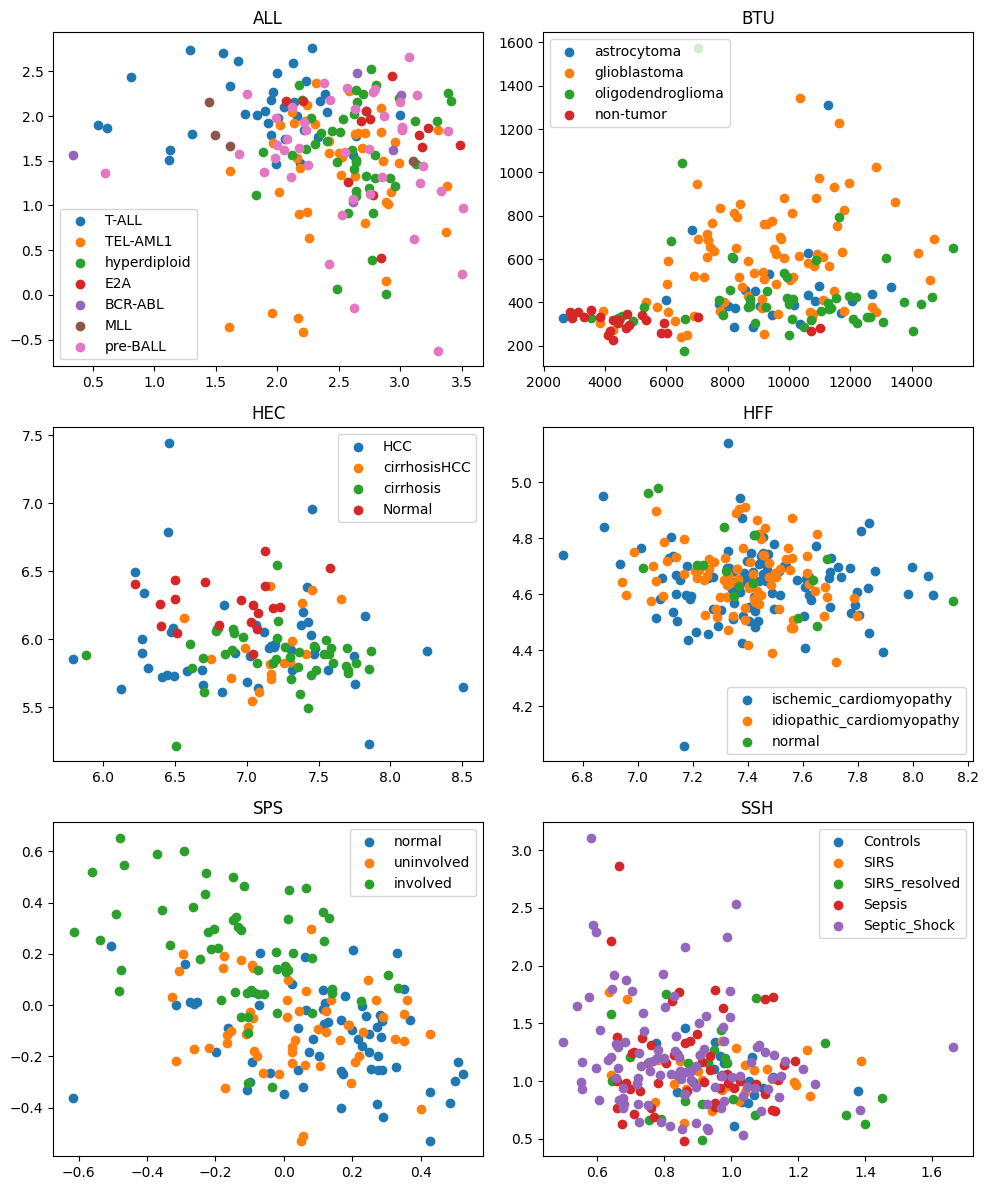

In [5]:
def plot_datasets(datasets):
    n_plots = len(datasets)
    cols = 2
    rows = (n_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    axes = axes.flatten()
    for idx, (name, data) in enumerate(datasets.items()):
        print(f"Tworzenie wykresu {name}...")
        X = data.drop(columns=[CLASS, SAMPLE_ID]).values
        y = data[CLASS].values
        
        # summarize class distribution
        counter = Counter(y)
        ax = axes[idx]
        print(counter)
        # scatter plot of examples by class label
        for label, _ in counter.items():
            row_ix = where(y == label)[0]
            ax.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        ax.set_title(name)
        ax.legend()

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_datasets(datasets)

Funkcja ogólna klasyfikacji


In [ ]:
def run_classification(
        classifier, 
        oversampler=None, 
        undersampler=None, 
        plot_resampled=False, 
        label=""
    ):
    plot_resampdle = plot_resampled and (oversampler or undersampler)
    
    if plot_resampled:
        n_datasets = len(datasets)
        cols = 3
        rows = (n_datasets + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten()
        plot_index = 0
        
        
        
    res = {}
    for name, data in datasets.items():
        X = data.drop(columns=[CLASS, SAMPLE_ID]).values
        y = data[CLASS].values

        steps = []
        if oversampler:
            steps.append(("over", oversampler))
        if undersampler:
            steps.append(("under", undersampler))
        steps.append(("model", classifier))

        pipeline = Pipeline(steps=steps)

        cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=RNG)
        scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
        score = mean(scores)
        #todo = std() Dorobić odchylenie standardowe
        

        print(f"F1 Score ({name} – {label}): {score:.3f}")
        # TODO : Dołożyć tradycyjne accuracy, balance_accuracy, precision, recall

        result = {
            "dataset": name,
            "label": label,
            "f1_score": score
        }

        if plot_resampled:
            resample_steps = steps.copy()
            resample_steps.pop()
            res_pipeline = Pipeline(resample_steps)

            X_res, y_res = res_pipeline.fit_resample(X, y)

            counter = Counter(y_res)
            print("Rozkład po resamplingu:", counter)

            ax = axes[plot_index]
            plot_index += 1

            for label_ in counter:
                idx = np.where(y_res == label_)[0]
                ax.scatter(X_res[idx, 0], X_res[idx, 1], label=str(label_))

            ax.set_title(f"{name} – {label}")
            ax.legend()
        
        res[name] = result
    
    
    if plot_resampled:
        plt.tight_layout()
        plt.show()
    
    return res

Klasyfikacja na danych czystych (Drzewo decyzyjne)

In [ ]:
# TODO: Generować wyniki  w excelu. Modele w pętli robić.

res = run_classification(
        classifier=DecisionTreeClassifier(random_state=RNG),
        label="clean"
)
add_results("clean", res)

F1 Score (ALL – clean): 0.728
F1 Score (BTU – clean): 0.589
F1 Score (HEC – clean): 0.702
F1 Score (HFF – clean): 0.540
F1 Score (SPS – clean): 0.698
F1 Score (SSH – clean): 0.383


Klasyfikacja (oversampling)

In [8]:

res = run_classification(
    classifier=DecisionTreeClassifier(random_state=RNG),
    oversampler=RandomOverSampler(random_state=RNG),
    label="oversample"
    # plot_resampled=True
)

add_results("oversample", res)

F1 Score (ALL – oversample): 0.753
F1 Score (BTU – oversample): 0.570
F1 Score (HEC – oversample): 0.755
F1 Score (HFF – oversample): 0.546
F1 Score (SPS – oversample): 0.720
F1 Score (SSH – oversample): 0.366


Klasyfikacja (Over+Undersampling SMOTE)

In [9]:
res = run_classification(
        classifier=DecisionTreeClassifier(random_state=RNG),
        oversampler=SMOTE(k_neighbors=1, random_state=RNG),
        undersampler=RandomUnderSampler(random_state=RNG),
        label="smote_under"
        # plot_resampled=True
)

add_results("smote_under", res)

F1 Score (ALL – smote_under): 0.709
F1 Score (BTU – smote_under): 0.572
F1 Score (HEC – smote_under): 0.675
F1 Score (HFF – smote_under): 0.554
F1 Score (SPS – smote_under): 0.713
F1 Score (SSH – smote_under): 0.395


Klasyfikacja (Adasyn)

C:\Users\Toshi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Toshi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Toshi\AppData\Local\Packages\PythonSoftwareFoundation.

F1 Score (ALL – BorderlineSMote): nan


KeyboardInterrupt: 

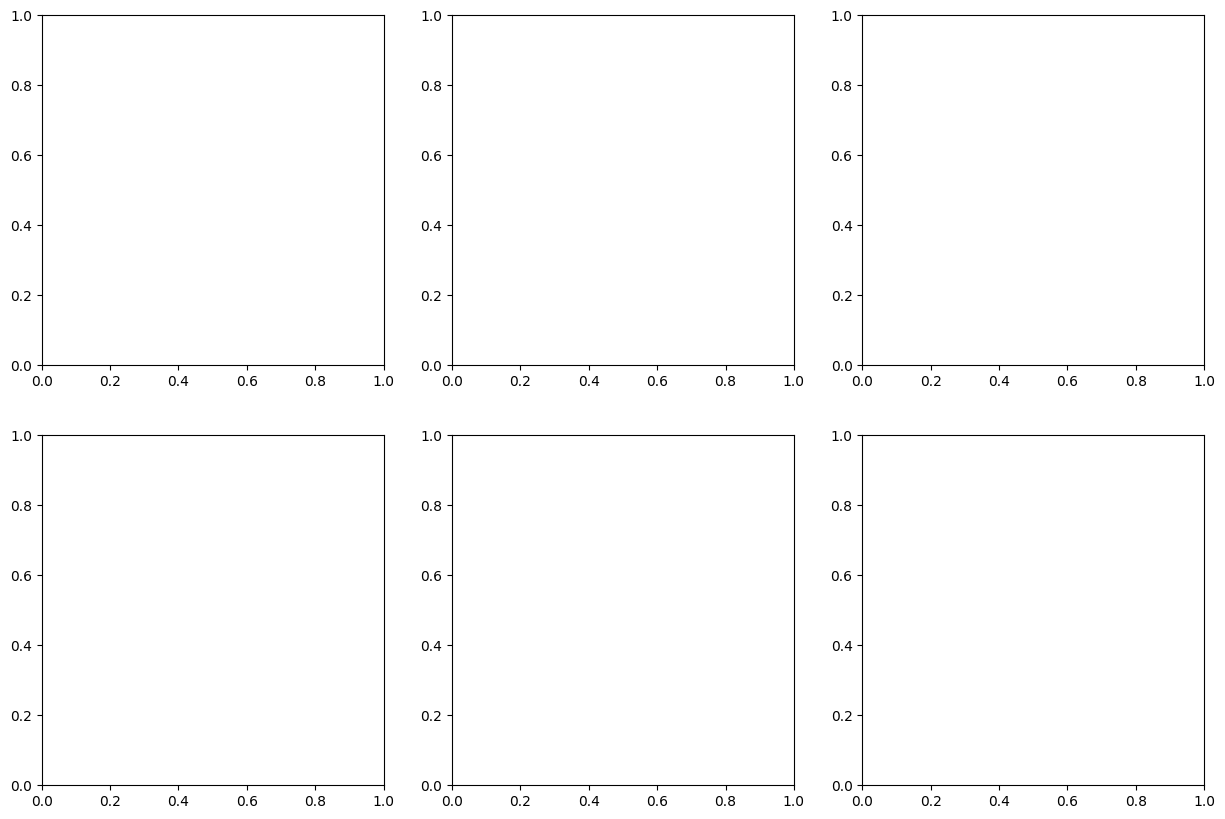

In [22]:
# res = run_classification(
#         classifier=DecisionTreeClassifier(random_state=RNG),
#         oversampler=BorderlineSMOTE(k_neighbors=1, random_state=RNG),
#         label="BorderlineSMote",
#         plot_resampled=True
#     )
# add_results("Borderline Smote", res)

from imblearn.over_sampling import SVMSMOTE
res = run_classification(
        classifier=DecisionTreeClassifier(random_state=RNG),
        oversampler= SVMSMOTE(k_neighbors=1, random_state=RNG),
        label="BorderlineSMote",
        plot_resampled=True
    )
add_results("Borderline Smote", res)

Klasyfikacja (Borderline SMOTE + Undersampling)

In [14]:
res = run_classification(
        classifier=DecisionTreeClassifier(random_state=RNG),
        oversampler=BorderlineSMOTE(k_neighbors=1, random_state=RNG),
        undersampler=RandomUnderSampler(random_state=RNG),
        label="BorderlineSmote + Undersampling" #,
        # plot_resampled=True
    )
add_results("Borderline Smote + Undersampling", res)

F1 Score (ALL – BorderlineSmote + Undersampling): 0.384
F1 Score (BTU – BorderlineSmote + Undersampling): 0.554
F1 Score (HEC – BorderlineSmote + Undersampling): 0.694
F1 Score (HFF – BorderlineSmote + Undersampling): 0.525
F1 Score (SPS – BorderlineSmote + Undersampling): 0.707
F1 Score (SSH – BorderlineSmote + Undersampling): 0.401


Klasyfikacja (AdaBoost)

In [11]:
res = run_classification(
        classifier=AdaBoostClassifier(n_estimators=25, random_state=RNG),
        oversampler=SMOTE(k_neighbors=1, random_state=RNG),
        undersampler=RandomUnderSampler(random_state=RNG),
        label="adaboost_smote_under"
        # plot_resampled=True
)

add_results("adaboost_smote_under", res)

F1 Score (ALL – adaboost_smote_under): 0.732
F1 Score (BTU – adaboost_smote_under): 0.559
F1 Score (HEC – adaboost_smote_under): 0.484
F1 Score (HFF – adaboost_smote_under): 0.548
F1 Score (SPS – adaboost_smote_under): 0.757
F1 Score (SSH – adaboost_smote_under): 0.451


Szybkie porównanie wyników

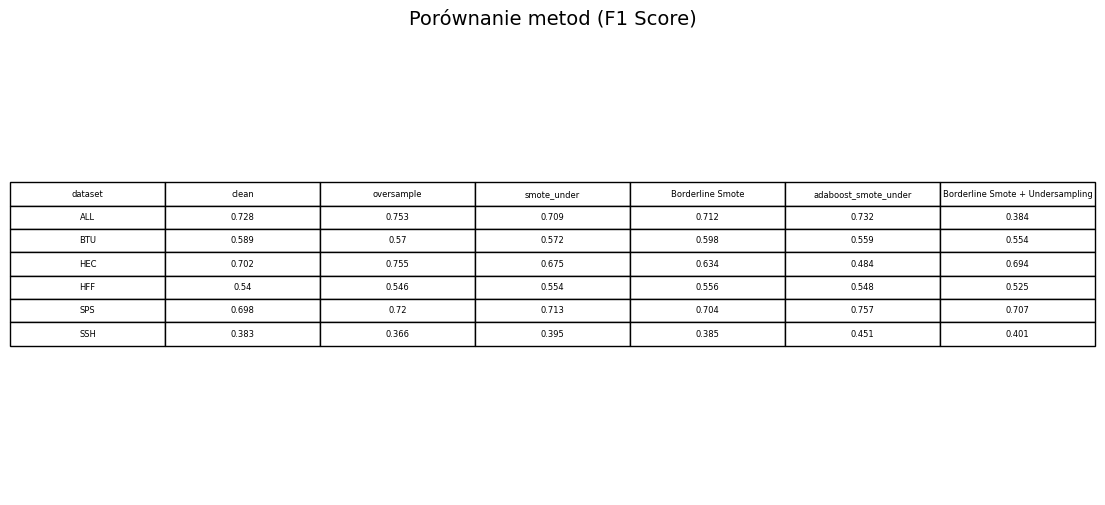

In [21]:
def build_table(all_results):
    methods = list(all_results.keys())
    datasets = sorted({ds for method in all_results.values() for ds in method.keys()})

    table = { "dataset": datasets }

    for method in methods:
        table[method] = []
        for ds in datasets:
            if ds in all_results[method]:
                table[method].append(all_results[method][ds]["f1_score"])
            else:
                table[method].append(None)

    df = pd.DataFrame(table)
    return df

def plot_comp(df):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center',
        cellLoc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(6)
    tbl.scale(1, 1.4)
    plt.title("Porównanie metod (F1 Score)", fontsize=14)
    plt.show()

plot_comp(build_table(all_results).round(3))

Uwagi:
- SMOTE ciężko jest zastosować na tym zbiorze danych, bo zbiór ALL posiada dwie klasy z 4-5 próbkami, przez co n_neighbours musi być bardzo małe
- Ogólnie dowolne metody kNN kuleją, jeśli używa się podziału na foldy
- ADASYN nie moze dokonać klasyfikacji bo problemy ze zbyt małym zbiorem danych.
- CVStratifiedKFold nie może być użyty w większych wartościach bo zbiór ALL posiada dwie klasy z 4-5 próbkami, a utworzenie foldu z n_splits >= 4 jest dla niej niemożliwe.
- AdaBoost jest ciężki obliczeniowo, ale daje najlepsze wyniki dla zbioru SSH, który ma najgorsze wyniki.
- Jeśli chodzi o wyniki, adaboost  nieźle poradził sobie ze zbiorami o niskim F1 score, ale miał problemy z ALL i HEC.
- Trzeba wypróbować jakiś lepszy sposób na oversampling, albo zamiast KFoldów użyć coś innego.
